# Using PyMC3 to fit a Linear Regression Model

Ram Narasimhan

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pymc3 as pm
import arviz as az

In [4]:
df = pd.read_csv('../data/marineblue_sales.csv')
df.rename(columns={'BEDS':'bdrms', 'SOLD PRICE': 'price'}, inplace=True)
df.head()

,UNIT,price,bdrms,BATHS,SQFT,FURNISHED,MAINT$,SOLD DATE
0,2909,470000,2,2.5,1323,NO,800.0,12/16/2019
1,5005,515000,2,2.0,1200,NO,789.0,12/2/2019
2,706,548500,2,2.5,1457,NO,950.0,9/20/2019
3,4703,385000,1,1.5,943,NO,620.0,9/18/2019
4,2412,459000,2,2.0,1318,NO,823.0,9/5/2019


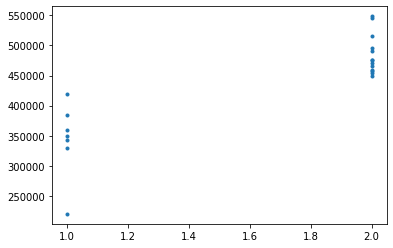

In [5]:
plt.plot(df['bdrms'], df['price'], '.')

As the plot above shows, it is not easy to "draw a line of best fit.' The prices are scattered for each of the 3 distinct bedroom counts. We could try and fit a linear regression model. But perhaps, a Bayesian model is even more relevant here. We want to understand the *range* of certain parameters.

In [6]:
df['bdrms'].values

array([2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1],
      dtype=int64)

In [8]:
bdrms = df['bdrms'].values
actual_prices = df['price'].values

MAX_BASE = 500000
MAX_PPB = 400000
MAX_SD = 200000

In [39]:
    
with pm.Model() as home_price_model:
    
    #define priors
    base = pm.Uniform('base_price', 0, MAX_BASE) # This is the price for a home with ZERO bedrooms
    ppb = pm.Uniform('price_per_bdrm', 0, MAX_PPB) #Additional cost for each bedroom 
    sigma = pm.HalfNormal('sigma', sd=MAX_SD)

    y_predicted = base + ppb * bdrms
    
    #define Likelihood
    likelihood = pm.Normal('y',
                           mu = y_predicted, sigma = sigma,
                           observed = actual_prices)
        

In [40]:
home_price_model

In [41]:
len(actual_prices) # Number of observations we have

20

# Ready to Start Sampling

We are going to sample (draw from) 10,000 times. Each attempt will get us one set of (m, x, and sigma).
If the error is "acceptable," we will randomly sample more in that neighborhood of m, x and sigam.
If the error is large, we will 'jump' elsewhere and try sampling there.
Note: the first 1000 values will be discarded. They are to warm-up the model.

In [42]:
with home_price_model:
    trace = pm.sample(2000, 
                      chains=2,
                      tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, price_per_bdrm, base_price]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████| 6000/6000 [04:45<00:00, 21.01draws/s]


### What do the results look like?

In [43]:
pm.summary(trace).round()

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
base_price,204746.0,39917.0,875.0,127267.0,284875.0,1619.0,1.0
price_per_bdrm,139885.0,23180.0,507.0,93058.0,185093.0,1643.0,1.0
sigma,48272.0,9029.0,224.0,32612.0,66258.0,1521.0,1.0


### Let us look at the Posterior

C:\Users\ramna\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\ramna\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\ramna\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


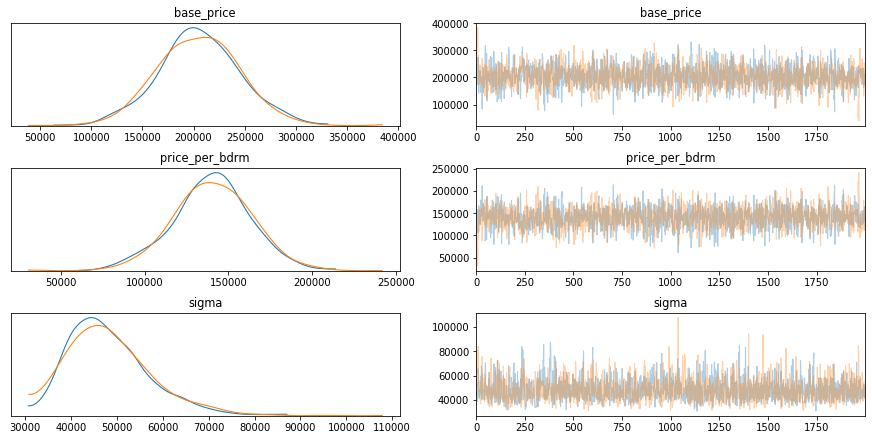

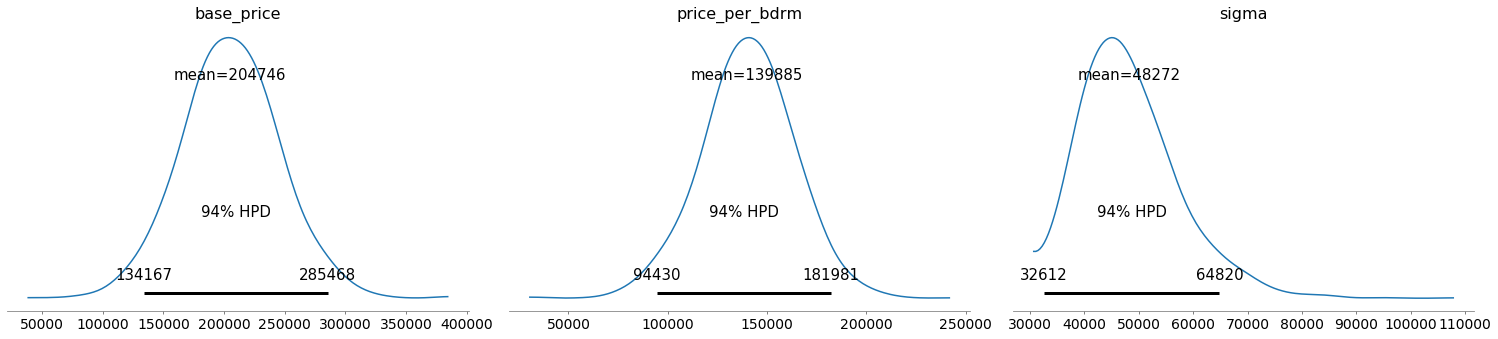

In [44]:
pm.traceplot(trace);
axes = pm.plot_posterior(trace)

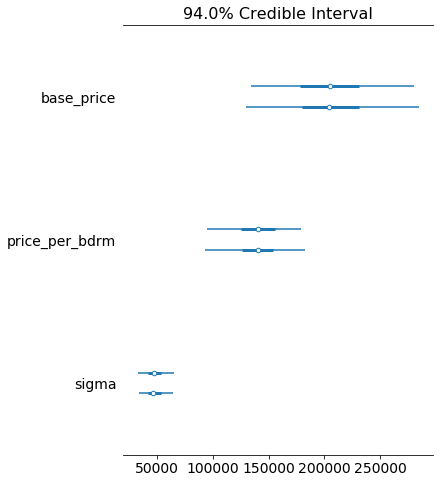

In [45]:
pm.forestplot(trace);

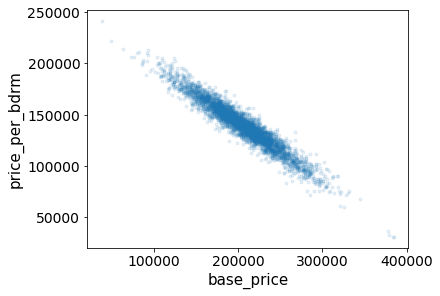

In [46]:
az.plot_pair(trace, var_names=['base_price', 'price_per_bdrm'], plot_kwargs={'alpha': 0.1})

In [47]:
len(trace)

2000

# Interpreting the Posterior

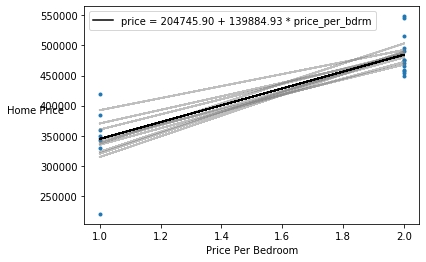

In [48]:
plt.plot(bdrms, actual_prices, 'C0.')

ppb = trace['price_per_bdrm'].mean()
intercept = trace['base_price'].mean()

draws = range(0, len(trace), 200)
plt.plot(bdrms, trace['base_price'][draws] + trace['price_per_bdrm'][draws]
         * bdrms[:, np.newaxis], c='gray', alpha=0.5)

plt.plot(bdrms, intercept + ppb * bdrms, c='k',
         label=f'price = {intercept:.2f} + {ppb:.2f} * price_per_bdrm')

plt.xlabel('Bedrooms')
plt.ylabel('Home Price')
plt.legend()

In [61]:
ppc = pm.sample_posterior_predictive(trace, samples=5000, model=home_price_model)


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:15<00:00, 331.99it/s]


### Peek inside Trace

It is perfectly okay to look under the hood.

In [65]:
len(trace)

2000

In [67]:
trace[1319]

{'base_price_interval__': 0.0942920009584543,
 'price_per_bdrm_interval__': -1.1039871537260866,
 'sigma_log__': 10.72069339688793,
 'base_price': 261777.77508098522,
 'price_per_bdrm': 99597.42703366051,
 'sigma': 45283.291251621195}

So trace is a List.
It is a list of dictionaries.
It is a list of 10,000 dictionaries

(array([ 8., 16., 18., 27., 15.,  7.,  6.,  1.,  1.,  1.]),
 array([ 94528.50046917, 109255.53982105, 123982.57917293, 138709.61852481,
        153436.65787669, 168163.69722857, 182890.73658044, 197617.77593232,
        212344.8152842 , 227071.85463608, 241798.89398796]),
 <a list of 10 Patch objects>)

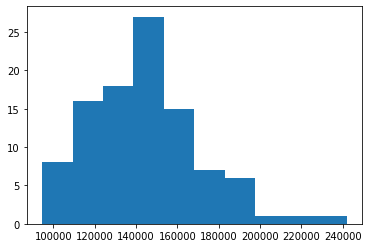

In [69]:
plt.hist([x['price_per_bdrm'] for x in trace[1900:]])